### Экперимент по повышению достоверности прогноза СОВ путем применения адаптивно-взвешенного конформного предиктора в классификаторе, полученным глубоким машинным обучением из датасета UNSW_NB15

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn

In [2]:
# Вычислительные ресурсы
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
train_path = '../DATA/UNSW/UNSW_NB15_training-set.parquet'
test_path = '../DATA/UNSW/UNSW_NB15_testing-set.parquet'

### 1. Загрузка и предобработка данных

In [4]:
# ---------------------------------------------------
# 1. Загрузка и предобработка данных
# ---------------------------------------------------
def load_and_preprocess_data(train_path, test_path):
    # Загрузка данных
    train_data = pd.read_parquet(train_path)
    test_data = pd.read_parquet(test_path)
    data = pd.concat([train_data, test_data], axis=0)
    
    # Удаление ненужных столбцов
    data.drop(columns=['id'], inplace=True, errors='ignore')
    
    # Разделение признаков и меток
    X = data.drop(columns=['label', 'attack_cat'])
    y = data['attack_cat']
    
    # Кодирование категориальных признаков
    cat_cols = ['proto', 'service', 'state']
    label_encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    
    # Кодирование целевой переменной
    label_encoder_y = LabelEncoder()
    y_encoded = label_encoder_y.fit_transform(y)
    num_classes = len(label_encoder_y.classes_)
    
    # Нормализация числовых признаков
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, num_classes, label_encoder_y, scaler, label_encoders

# Загрузка и предобработка данных
X, y, num_classes, label_encoder, scaler, feature_encoders = load_and_preprocess_data(train_path, test_path)

### 2. Разделение данных с учетом дисбаланса

In [5]:
# ---------------------------------------------------
# 2. Разделение данных с учетом дисбаланса
# ---------------------------------------------------
# Разделение на обучающий+калибровочный и тестовый наборы (80/20)
X_train_cal, X_test, y_train_cal, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Дальнейшее разделение на обучающий и калибровочный наборы (60/20 от общего)
X_train, X_cal, y_train, y_cal = train_test_split(
    X_train_cal, y_train_cal, test_size=0.25, stratify=y_train_cal, random_state=42  # 0.25 * 0.8 = 0.2
)

### 3. Расчет весов классов

In [6]:
# ---------------------------------------------------
# 3. Расчет весов классов
# ---------------------------------------------------
# def calculate_class_weights(y_train):
#     class_counts = np.bincount(y_train)
#     total_samples = len(y_train)
#     weights = total_samples / (len(class_counts) * class_counts)
#     return torch.tensor(weights, dtype=torch.float32).to(device)

# class_weights = calculate_class_weights(y_train)
# print("Веса классов:", class_weights.cpu().numpy())

# def calculate_class_weights(y_train):
#     class_counts = np.bincount(y_train)  
#     # Вариант 1: Сглаживающее взвешивание
#     class_weights = 1.0 / np.sqrt(class_counts + 1e-8)  
#     class_weights = class_weights / class_weights.sum()
#     return torch.tensor(class_weights, dtype=torch.float32).to(device)

# class_weights = calculate_class_weights(y_train)
# print("Веса классов:", class_weights.cpu().numpy())


def calculate_class_weights(y_train):
    class_counts = np.bincount(y_train)    
    min_cnt = float( class_counts.max() * 0.05 )  # 5% от мажоритарного класса
    min_count = torch.tensor(min_cnt)
    adjusted_counts = torch.clamp(torch.tensor(class_counts), min=min_count)
    class_weights = 1.0 / adjusted_counts.float()
    class_weights = class_weights / class_weights.sum()
    return class_weights.clone().detach().to(device, dtype=torch.float32) 
class_weights = calculate_class_weights(y_train)
print("Веса классов:", class_weights.cpu().numpy())

Веса классов: [0.19833265 0.19833265 0.05640079 0.02071301 0.03803603 0.01566538
 0.00991663 0.06593758 0.19833265 0.19833265]


### 4. Подготовка DataLoader

In [7]:
# ---------------------------------------------------
# 4. Подготовка DataLoader
# ---------------------------------------------------
# Функция для создания тензоров и DataLoader
def create_dataloader(X, y, batch_size=64, shuffle=False):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Создание DataLoader
batch_size = 256
train_loader = create_dataloader(X_train, y_train, batch_size, shuffle=True)
cal_loader = create_dataloader(X_cal, y_cal, batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size)

### 5. Архитектура модели классификатора

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.3):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim * 2)  # Удвоение размерности для GLU
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim * 2)
        self.bn2 = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Проекция для skip-connection при изменении размерности
        self.shortcut = nn.Sequential()
        if in_dim != out_dim:
            self.shortcut = nn.Sequential(
                nn.Linear(in_dim, out_dim),
                nn.BatchNorm1d(out_dim) )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        # GLU-активация: [A, B] -> A * sigmoid(B)
        out = self.linear1(x)
        out = self.bn1(out)
        A, B = torch.chunk(out, 2, dim=1)
        out = A * torch.sigmoid(B)
        
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        
        out += identity
        return out

class GLU_ResNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2)
        )
        
        # Последовательность остаточных блоков
        self.res_blocks = nn.Sequential(
            ResidualBlock(256, 256, dropout=0.25),
            ResidualBlock(256, 256, dropout=0.3),
            ResidualBlock(256, 128, dropout=0.35),
            ResidualBlock(128, 128, dropout=0.4)
        )
        
        # Финальные слои
        self.final = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
        # Инициализация весов
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.final(x)

### 6. Инициализация модели

In [9]:
# Инициализация модели
model = GLU_ResNet(X_train.shape[1], num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

### 7. Обучение модели

In [10]:
# ---------------------------------------------------
# 7. Обучение модели
# ---------------------------------------------------
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}')
    return model

# Обучение модели
# model = train_model(model, train_loader, criterion, optimizer, epochs=100)

### 8. Подготовка для развертывания конформного предиктора (сохранение весов модели)

In [ ]:
# ---------------------------------------------------
# 8. Подготовка для конформного предиктора
# ---------------------------------------------------
# Для конформного предиктора нам нужны:
# - Обученная модель
# - Калибровочный набор данных
# - Функция неконформности (обычно 1 - предсказанная вероятность истинного класса)
path_model = 'model_GLU_ResNet_50.pth'
# Сохраним калибровочные данные и метки
# Вместо сохранения полных объектов:
# Правильное сохранение весов классов
# torch.save({
#     'cal_features': X_cal.cpu().numpy() if torch.is_tensor(X_cal) else X_cal,
#     'cal_labels': y_cal.cpu().numpy() if torch.is_tensor(y_cal) else y_cal,
#     'test_features': X_test.cpu().numpy() if torch.is_tensor(X_test) else X_test, # torch.tensor(X_test),
#     'test_labels': y_test.cpu().numpy() if torch.is_tensor(y_test) else y_test, #torch.tensor(y_test),
#     'model_state_dict': model.state_dict(),
#     'class_weights': class_weights.cpu().numpy(),  # Ключевое исправление
#     'label_encoder_classes': label_encoder.classes_,
# }, path_model)

# print("Данные для конформного предиктора сохранены в ", path_model)

### 9. Взвешенный конформный предиктор с адаптивными весами

In [12]:
def adaptive_weighted_conformal_predictor(model, cal_features, cal_labels, test_features, 
                                        class_weights, alpha=0.1, temperature=1.0):
    """
    Взвешенный конформный предиктор с адаптивными весами
    
    Параметры:
    model: Обученная модель PyTorch
    cal_features: Калибровочные данные (тензор)
    cal_labels: Калибровочные метки (тензор)
    test_features: Тестовые данные (тензор)
    class_weights: Веса классов (тензор)
    alpha: Уровень значимости
    temperature: Температура для калибровки
    """
    device = next(model.parameters()).device
    
    # 1. Получение предсказаний для калибровочного набора
    with torch.no_grad():
        cal_logits = model(cal_features.to(device))
        cal_probs = F.softmax(cal_logits / temperature, dim=1)
        cal_labels = cal_labels.to(device)  # Переносим метки на то же устройство
    
    # 2. Вычисление неконформных мер
    n = len(cal_labels)
    indices = torch.arange(n, device=device)  # Убедимся, что индексы на том же устройстве, что и cal_probs
    cal_scores = 1 - cal_probs[indices, cal_labels]
    
    # 3. Расчёт адаптивных весов
    class_distribution = cal_probs.mean(dim=0)
    adaptive_weights = class_weights * (1 / (class_distribution + 1e-8))
    adaptive_weights = adaptive_weights / adaptive_weights.sum() * class_weights.sum()
    adaptive_weights = adaptive_weights / adaptive_weights.sum()
    
    # 4. Применение весов
    sample_weights = adaptive_weights[cal_labels]
    
    # 5. Вычисление взвешенного квантиля
    sorted_indices = torch.argsort(cal_scores)
    sorted_scores = cal_scores[sorted_indices]
    sorted_weights = sample_weights[sorted_indices]
    
    cum_weights = torch.cumsum(sorted_weights, dim=0)
    total_weight = cum_weights[-1]
    quantile_level = (1 - alpha) * total_weight
    
    quantile_idx = torch.searchsorted(cum_weights, quantile_level).item()
    quantile_value = sorted_scores[quantile_idx] if quantile_idx < n else float('inf')
    
    # 6. Предсказание для тестовых данных
    with torch.no_grad():
        test_logits = model(test_features.to(device))
        test_probs = F.softmax(test_logits / temperature, dim=1)
    
    # 7. Построение предсказанных наборов
    prediction_sets = []
    for probs in test_probs:
        class_scores = 1 - probs
        prediction_set = (class_scores <= quantile_value).nonzero(as_tuple=True)[0].tolist()
        prediction_sets.append(prediction_set)
    
    return prediction_sets, quantile_value, adaptive_weights

### 10. Загрузка сохраненных данных (перед вызовом конформного предиктора) 

In [13]:
from sklearn.preprocessing import LabelEncoder

# Загрузка сохраненных данных (перед вызовом конформного предиктора)
checkpoint = torch.load(path_model, weights_only=False)  # Или safe_data.pth, если использовали безопасное сохранение

# Восстановление необходимых объектов
label_encoder = LabelEncoder()
label_encoder.classes_ = checkpoint['label_encoder_classes']

#print("Доступные ключи в checkpoint:", checkpoint.keys())

# # Восстановление данных
# cal_features = torch.from_numpy(checkpoint['cal_features']).float().to(device)
# cal_labels = torch.from_numpy(checkpoint['cal_labels']).long().to(device)
# test_features = torch.from_numpy(checkpoint['test_features']).float().to(device)
# class_weights = torch.from_numpy(checkpoint['class_weights']).float().to(device)


# Перенос данных на нужное устройство (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(checkpoint['class_weights']).to(device)

In [14]:
cal_features = torch.from_numpy(checkpoint['cal_features']).float().to(device)
cal_labels = torch.from_numpy(checkpoint['cal_labels']).long().to(device)
test_features = torch.from_numpy(checkpoint['test_features']).float().to(device)
test_labels = torch.from_numpy(checkpoint['test_labels']).float().to(device)
class_weights = torch.from_numpy(checkpoint['class_weights']).float().to(device)

In [15]:
# Создаем экземпляр модели (должен соответствовать сохраненной архитектуре)
model = GLU_ResNet(input_dim=checkpoint['cal_features'].shape[1], 
                    num_classes=len(label_encoder.classes_)).to(device)

# Загружаем веса модели
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Переводим в режим оценки

GLU_ResNet(
  (initial): Sequential(
    (0): Linear(in_features=34, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.2, inplace=False)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (linear2): Linear(in_features=256, out_features=256, bias=True)
      (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.25, inplace=False)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (linear1): Linear(in_features=256, out_features=512, bias=True)
      (linear2): Linear(in_features=256, out_features=256, bias=True)
      (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2):

### 11. Оптимизация температуры

Найдем оптимальную температуру на валидационном наборе, чтобы минимизировать негативную логарифмическую вероятность (NLL) или максимизировать точность.

In [16]:
def tune_temperature(model, val_loader, temperatures=[0.1, 0.2, 0.3, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.3, 1.5, 1.7, 1.9, 2.0]):
    best_temp = 1.0
    best_nll = float('inf')
    device = next(model.parameters()).device
    for temp in temperatures:
        nll = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)
                probs = F.softmax(logits / temp, dim=1)
                # Вычисляем NLL
                nll += F.nll_loss(probs.log(), labels).item() * inputs.size(0)
        nll /= len(val_loader.dataset)
        if nll < best_nll:
            best_nll = nll
            best_temp = temp
    return best_temp

In [17]:
# b_tm = tune_temperature(model, cal_loader)
# b_tm

### 12. Применение АВКП к модели классификатора

In [18]:
# Параметры конформного предсказания
alpha = 0.05  # 95% доверительный интервал
temperature = 0.95 # Оптимальное значение, можно подобрать на валидации

# Вызов функции (после определения всех переменных)
awcp_prediction_sets, awcp_quantile, awcp_adaptive_weights = adaptive_weighted_conformal_predictor(
    model=model,
    cal_features=torch.from_numpy(checkpoint['cal_features']).float().to(device),
    cal_labels=torch.from_numpy(checkpoint['cal_labels']).long().to(device),
    test_features=torch.from_numpy(checkpoint['test_features']).float().to(device),
    class_weights=class_weights,
    alpha=alpha,
    temperature=temperature
)

#### Предварительная оценка АВКП

In [19]:
# ---------------------------------------------------
# Оценка результатов
# ---------------------------------------------------

def evaluate_predictions(prediction_sets, true_labels):
    coverage = sum(1 for i, true in enumerate(true_labels) if true in prediction_sets[i]) / len(true_labels)
    
    set_sizes = [len(s) for s in prediction_sets]
    avg_size = np.mean(set_sizes)
    
    return coverage, avg_size

# Оценка покрытия и размера наборов
test_labels_np = torch.from_numpy(checkpoint['test_labels']).float().to(device) # checkpoint['test_labels'].numpy()
coverage, avg_size = evaluate_predictions(awcp_prediction_sets, test_labels_np)

print(f"Coverage: {coverage:.4f} | Average set size: {avg_size:.2f}")
print(f"Adaptive weights: {awcp_adaptive_weights.cpu().numpy()}")
print(f"Quantile value: {awcp_quantile:.4f}")



Coverage: 0.9894 | Average set size: 2.43
Adaptive weights: [3.5471477e-02 5.0046049e-02 4.7292905e-03 1.5477068e-03 2.5284463e-03
 8.1515312e-04 4.4313903e-04 5.8163423e-03 9.3615606e-02 8.0498677e-01]
Quantile value: 0.9719


In [20]:
# ---------------------------------------------------
# Анализ по классам
# ---------------------------------------------------
# Переносим метки на CPU и конвертируем в NumPy
test_labels_np = test_labels_np.cpu().numpy()

class_coverages = []
for class_idx in range(num_classes):
    class_mask = (test_labels_np == class_idx)
    if class_mask.sum() > 0:
        class_coverage = sum(1 for i in np.where(class_mask)[0] 
                          if test_labels_np[i] in awcp_prediction_sets[i]) / class_mask.sum()
        class_coverages.append((class_idx, class_coverage))

print("\nClass-wise coverage:")
awcp_class_coverages = {}
for class_idx, coverage in sorted(class_coverages, key=lambda x: x[1]):
    class_name = label_encoder.inverse_transform([class_idx])[0]
    print(f"{class_name:15s}: {coverage:.4f}")
    awcp_class_coverages[class_name] = coverage


Class-wise coverage:
Worms          : 0.8286
Shellcode      : 0.9040
Backdoor       : 0.9614
DoS            : 0.9746
Generic        : 0.9840
Analysis       : 0.9888
Reconnaissance : 0.9904
Exploits       : 0.9915
Fuzzers        : 0.9938
Normal         : 0.9955


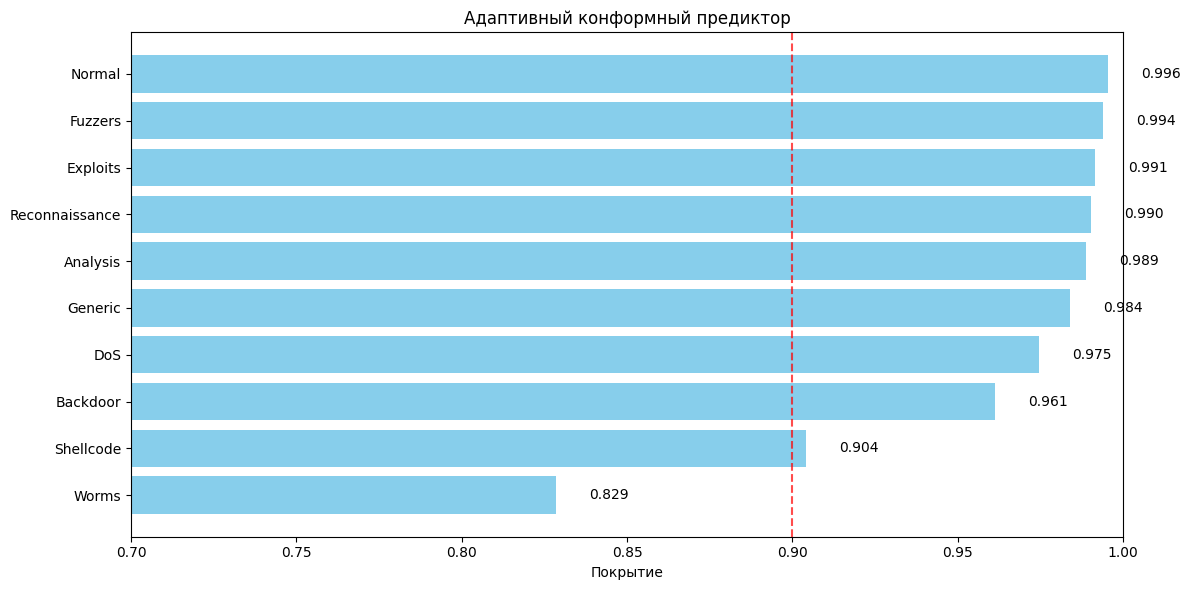

In [21]:
def plot_class_coverage(class_coverages, title="Покрытие по классам"):
    """Визуализация покрытия по классам"""
    classes = list(class_coverages.keys())
    coverages = list(class_coverages.values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(classes, coverages, color='skyblue')
    plt.axvline(x=0.9, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Покрытие')
    plt.title(title)
    plt.xlim(0.7, 1.0)
    
    # Добавляем значения на бары
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

# Использование:
plot_class_coverage(awcp_class_coverages, "Адаптивный конформный предиктор")

### 13. Определение практической ценности AWCP через взвешенные метрики ошибок

In [22]:
for id, c in enumerate(label_encoder.classes_):
    print('id =', id,' class ', c)

id = 0  class  Analysis
id = 1  class  Backdoor
id = 2  class  DoS
id = 3  class  Exploits
id = 4  class  Fuzzers
id = 5  class  Generic
id = 6  class  Normal
id = 7  class  Reconnaissance
id = 8  class  Shellcode
id = 9  class  Worms


In [23]:
#apt_label = 1 # Метка APT класса "Backdoor"
#apt_label = 7 # Метка APT класса 'Reconnaissance'
apt_label = 9 # Метка редкого в данных класса 'Worms'
#apt_label = 3 # Метка APT класса "Exploits"

# Правило: Объект считается "APT-подозрительным", если содержит:
# [Reconnaissance ИЛИ Fuzzers] И [Exploits] И [Backdoor ИЛИ Shellcode]
def is_apt_suspicious(row):
    return (row['Reconnaissance'] or row['Fuzzers']) and \
           (row['Exploits']) and \
           (row['Backdoor'] or row['Shellcode'])

def calculate_wFNR(y_true, prediction_sets, class_weights):
    """Расчет взвешенного False Negative Rate"""
    fn_numerator = 0.0
    denominator = 0.0
    
    for cls, weight in class_weights.items():
        cls_mask = (y_true == cls)
        N_k = np.sum(cls_mask)
        
        if N_k == 0:
            continue
            
        # Подсчет FN для класса
        fn_count = 0
        for i in np.where(cls_mask)[0]:
            if cls not in prediction_sets[i]:
                fn_count += 1
                
        fn_numerator += weight * fn_count
        denominator += weight * N_k
        
    return fn_numerator / denominator if denominator > 0 else 0.0

def calculate_wFPR(y_true, prediction_sets, class_weights):
    """Расчет взвешенного False Positive Rate"""
    fp_numerator = 0.0
    denominator = 0.0
    
    for cls, weight in class_weights.items():
        cls_mask = (y_true != cls)
        N_not_k = np.sum(cls_mask)
        
        if N_not_k == 0:
            continue
            
        # Подсчет FP для класса
        fp_count = 0
        for i in np.where(cls_mask)[0]:
            if cls in prediction_sets[i]:
                fp_count += 1
                
        fp_numerator += weight * fp_count
        denominator += weight * N_not_k
        
    return fp_numerator / denominator if denominator > 0 else 0.0

def calculate_coverage(y_true, prediction_sets):
    """Расчет покрытия (Coverage)"""
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in prediction_sets[i]:
            correct += 1
    return correct / len(y_true)

def calculate_avg_size(prediction_sets):
    """Расчет среднего размера множества"""
    sizes = [len(s) for s in prediction_sets]
    return np.mean(sizes)

def calculate_class_size(y_true, prediction_sets, target_class):
    """Расчет среднего размера множества для конкретного класса"""
    class_indices = np.where(y_true == target_class)[0] 
    if len(class_indices) == 0:
        return 0.0
    sizes = [len(prediction_sets[i]) for i in class_indices]
    return np.mean(sizes)

# Расчет метрик для базового классификатора
def base_classifier_metrics(y_true, y_pred, class_weights):
    """Расчет wFNR и wFPR для базового классификатора"""
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    wFNR = 0.0
    wFPR = 0.0
    wFNR_denom = 0.0
    wFPR_denom = 0.0
    
    for i, true_cls in enumerate(classes):
        weight = class_weights.get(true_cls, 1.0)
        # False Negative для класса
        fn = np.sum(cm[i, :]) - cm[i, i] if i < len(cm) else 0
        wFNR += weight * fn
        wFNR_denom += weight * np.sum(y_true == true_cls)
        
        # False Positive для класса
        fp = np.sum(cm[:, i]) - cm[i, i] if i < len(cm) else 0
        wFPR += weight * fp
        wFPR_denom += weight * np.sum(y_true != true_cls)
    
    return (wFNR / wFNR_denom if wFNR_denom > 0 else 0.0,
            wFPR / wFPR_denom if wFPR_denom > 0 else 0.0)

# Расчет метрик для всех моделей
def calculate_all_metrics(model_name, y_true, predictions, class_weights, apt_label):
    """Расчет всех метрик для модели"""
    metrics = {'Model': model_name}
    
    if isinstance(predictions, np.ndarray):
        # Базовый классификатор
        metrics['wFNR'], metrics['wFPR'] = base_classifier_metrics(
            y_true, predictions, class_weights
        )
        metrics['Coverage'] = np.nan
        metrics['AvgSize'] = 1.0  # Всегда один класс
        metrics['Size_APT'] = 1.0
    else:
        # Конформные предикторы
        metrics['wFNR'] = calculate_wFNR(y_true, predictions, class_weights)
        metrics['wFPR'] = calculate_wFPR(y_true, predictions, class_weights)
        metrics['Coverage'] = calculate_coverage(y_true, predictions)
        metrics['AvgSize'] = calculate_avg_size(predictions)
        metrics['Size_APT'] = calculate_class_size(
            y_true, predictions, apt_label
        )
    
    return metrics

In [24]:
# Оценка обычного классификатора без CP
# Проверяем устройство, на котором находится модель
device = next(model.parameters()).device
# Конвертируем данные в тензор и перемещаем на то же устройство, что и модель
y_pred_base = model(torch.tensor(X_test, dtype=torch.float32).to(device)).argmax(dim=1).cpu().numpy()
base_accuracy = np.mean(y_pred_base == y_test)
print(base_accuracy)

0.7601824003104686


In [25]:
# Стандартный конформный предиктор (без весов)
def standard_conformal(model, cal_features, cal_labels, test_features, alpha):
    cal_scores = 1 - model(cal_features).softmax(dim=1)[torch.arange(len(cal_labels)), cal_labels]
    q = (1-alpha) * (1+1/len(cal_labels))
    quantile = np.quantile(cal_scores.detach().cpu().numpy(), q)
    
    test_probs = model(test_features).softmax(dim=1)
    return [torch.where(1-test_probs[i] <= quantile)[0].tolist() for i in range(len(test_features))]

cp_pred_sets = standard_conformal(model, cal_features, cal_labels, test_features, alpha)
#print(f"STANDARD CP: Coverage={calculate_coverage(cp_pred_sets, y_test):.3f}, Size={np.mean([len(s) for s in cp_pred_sets]):.2f}")

In [26]:
# Сравнение моделей
results = []

class_weights_dict = {i: float(w) for i, w in enumerate(class_weights)}

# 1. Базовый классификатор
results.append(calculate_all_metrics(
    "Base Classifier", y_test, y_pred_base, class_weights_dict, apt_label
))

# 2. Стандартный конформный предиктор
results.append(calculate_all_metrics(
    "Conformal Predictor", y_test, cp_pred_sets, class_weights_dict, apt_label
))

# 3. Адаптивно-взвешенный конформный предиктор
results.append(calculate_all_metrics(
    "Adaptive Weighted CP", y_test, awcp_prediction_sets, class_weights_dict, apt_label
))

# Форматирование и вывод результатов
print("\nСравнение моделей:")
print("-" * 65)
print(f"{'Model':<25} | {'wFNR':<8} | {'wFPR':<8} | {'Coverage':<8} | {'AvgSize':<8} | {'Size_APT':<8}")
print("-" * 65)

for res in results:
    print(f"{res['Model']:<25} | {res['wFNR']:.6f} | {res['wFPR']:.6f} | ", end="")
    
    if np.isnan(res['Coverage']):
        print(f"{'N/A':<8} | ", end="")
    else:
        print(f"{res['Coverage']:.6f} | ", end="")
    
    print(f"{res['AvgSize']:.6f} | {res['Size_APT']:.6f}")

print("-" * 65)


Сравнение моделей:
-----------------------------------------------------------------
Model                     | wFNR     | wFPR     | Coverage | AvgSize  | Size_APT
-----------------------------------------------------------------
Base Classifier           | 0.301585 | 0.010850 | N/A      | 1.000000 | 1.000000
Conformal Predictor       | 0.085927 | 0.048277 | 0.948443 | 1.732221 | 2.000000
Adaptive Weighted CP      | 0.015876 | 0.092614 | 0.989405 | 2.426972 | 3.457143
-----------------------------------------------------------------


#### Эффективность AВКП:

1. Практическая полезность:

- Крайний низкий wFNR (1.59%) означает максимальное число обнаруженных критических угроз
- Высокий wFPR (9.26%) показывает, что практически в 10 случаях из 100 инцидентов возможны ложные тревоги

2. Сравнение с базой:

Если стандартный конформный предиктор дает:

- wFNR = 8.59% (пропускает в 5 раз больше атак)

- wFPR = 4.83% (меньше ложных срабатываний)

Тогда выигрыш АВКП: $\Delta \text{wFNR} = +7.00 %$, но есть и проигрыш: $\Delta \text{wFPR} = -4.43%$

### 14. Определение ложных срабатываний для нормального трафика

* Базовый CNN-BiGRU: Ложное срабатывание - когда модель предсказывает класс атаки, а истинный класс - нормальный трафик.

* Конформный предиктор и APS: Ложное срабатывание - когда нормальный класс (0) не включен в предсказательный набор для нормального трафика.

In [27]:
def evaluate_performance(pred_sets, true_labels, label_encoder=None):
    """
    Оценка производительности конформного предиктора
    
    Args:
        pred_sets: список предсказанных множеств (каждый элемент - список классов)
        true_labels: тензор истинных меток
        label_encoder: опционально, для преобразования имен классов
    
    Returns:
        Словарь с метриками производительности
    """
    # Преобразуем тензор в numpy array
    if isinstance(true_labels, torch.Tensor):
        true_labels_np = true_labels.cpu().numpy()
    else:
        true_labels_np = true_labels
    
    # 1. Общее покрытие
    coverage = np.mean([true in pred for pred, true in zip(pred_sets, true_labels_np)])
    
    # 2. Средний размер множества
    avg_size = np.mean([len(ps) for ps in pred_sets])
    
    # 3. Класс-специфичное покрытие
    unique_classes = np.unique(true_labels_np)
    class_coverages = {}
    class_coverage_values = []
    
    for cls in unique_classes:
        # Получаем индексы элементов этого класса
        cls_indices = np.where(true_labels_np == cls)[0]
        
        if len(cls_indices) > 0:
            # Собираем предсказания только для этого класса
            cls_preds = [pred_sets[i] for i in cls_indices]
            cls_true = true_labels_np[cls_indices]
            
            # Вычисляем покрытие для класса
            cls_cov = np.mean([true in pred for pred, true in zip(cls_preds, cls_true)])
            
            # Сохраняем с именем класса, если есть encoder
            if label_encoder:
                cls_name = label_encoder.inverse_transform([cls])[0]
                class_coverages[cls_name] = cls_cov
            else:
                class_coverages[str(cls)] = cls_cov
                
            class_coverage_values.append(cls_cov)
    
    # 4. Стандартное отклонение покрытий классов
    cov_balance = np.std(class_coverage_values) if class_coverage_values else 0
    
    # 5. Эффективность
    num_classes = len(unique_classes)
    efficiency = (1 - avg_size/num_classes) * 100 if num_classes > 0 else 0
    
    return {
        'coverage': coverage,
        'avg_size': avg_size,
        'cov_balance': cov_balance,
        'efficiency': efficiency,
        'class_coverages': class_coverages
    }

In [28]:
def calculate_fpr_base(model, test_loader, normal_class=0):
    """Вычисление FPR для базовой модели"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    
    y_true = torch.cat(all_targets).numpy()
    global y_pred
    y_pred = torch.cat(all_preds).numpy()

    # Фильтруем только нормальные образцы
    normal_mask = (y_true == normal_class)
    y_true_normal = y_true[normal_mask]
    y_pred_normal = y_pred[normal_mask]
    
    # Ложные срабатывания: предсказана атака на нормальном трафике
    fp = np.sum(y_pred_normal != normal_class)
    total_normal = len(y_true_normal)
    
    return fp / total_normal if total_normal > 0 else 0

def calculate_fpr_aps(prediction_sets, true_labels, normal_class=0):
    """Вычисление FPR для конформного предиктора и APS"""
    normal_mask = (np.array(true_labels) == normal_class)
    normal_sets = [s for i, s in enumerate(prediction_sets) if normal_mask[i]]
    
    # Ложные срабатывания: нормальный класс отсутствует в наборе
    fp = sum(normal_class not in s for s in normal_sets)
    total_normal = len(normal_sets)
    
    return fp / total_normal if total_normal > 0 else 0

In [29]:
NORMAL_CLASS = 6  # Класс нормального трафика
NUM_CLASSES = 10 

# 1. FPR для базовой модели
base_fpr = calculate_fpr_base(model, test_loader, normal_class=NORMAL_CLASS)

# 2. FPR для стандартного конформного предиктора (равные веса)
cp_standard_fpr = calculate_fpr_aps(cp_pred_sets, y_test, normal_class=NORMAL_CLASS)

# 3. FPR для взвешенного APS
weighted_fpr = calculate_fpr_aps(awcp_prediction_sets, y_test, normal_class=NORMAL_CLASS)

std_metrics = evaluate_performance(cp_pred_sets, y_test)
acp_metrics = evaluate_performance(awcp_prediction_sets, y_test)

# 4. Вывод результатов
print("\n" + "="*50)
print("False Positive Rate Comparison:")
print(f"Base Model FPR: {base_fpr:.4f}")
print(f"Standard Conformal FPR: {cp_standard_fpr:.4f}")
print(f"Weighted APS FPR: {weighted_fpr:.4f}")
print("="*50)

# 5. Дополнительные метрики

def print_metrics(fpr_dict):
    print("\n{:<25} {:<10} {:<10} {:<10}".format('Method', 'FPR', 'Coverage', 'Avg Size'))
    for name, metrics in fpr_dict.items():
        # Заменяем None на 0.0
        fpr = metrics['fpr'] if metrics['fpr'] is not None else 0.0
        coverage = metrics['coverage'] if metrics['coverage'] is not None else 0.0
        avg_size = metrics['avg_size'] if metrics['avg_size'] is not None else 0.0

        print("{:<25} {:<10.4f} {:<10.4f} {:<10.2f}".format(
                name, fpr, coverage, avg_size))
        # print("{:<25} {:<10.4f} {:<10.4f} {:<10.2f}".format(
        #     name, metrics['fpr'], metrics['coverage'], metrics['avg_size']))

# Сбор всех метрик
results = {
    "Base Model": {
        "fpr": base_fpr,
        "coverage": None,  # Нет coverage для точечного предсказания
        "avg_size": 1.0    # Всегда 1 класс
    },
    "Standard Conformal": {
        "fpr": cp_standard_fpr,
        "coverage": std_metrics['coverage'],
        "avg_size": std_metrics['avg_size']
    },
    "Weighted APS": {
        "fpr": weighted_fpr,
        "coverage": acp_metrics['coverage'],
        "avg_size": acp_metrics['avg_size']
    }
}

print_metrics(results)


False Positive Rate Comparison:
Base Model FPR: 0.1981
Standard Conformal FPR: 0.0113
Weighted APS FPR: 0.0045

Method                    FPR        Coverage   Avg Size  
Base Model                0.1981     0.0000     1.00      
Standard Conformal        0.0113     0.9484     1.73      
Weighted APS              0.0045     0.9894     2.43      


### 15. Зависимость ключевых метрик от целевого уровня доверия (confidence level) для оценки свойств предсказательных интервалов при изменении требуемой надежности

In [30]:
alphas = [0.10, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
coverageS = []
avg_sizeS = []
quantileS = []
class_coveragesS = {}
for alpha in alphas:
    
    prediction_sets, quantile, adaptive_weights = adaptive_weighted_conformal_predictor(
    model=model,
    cal_features=torch.from_numpy(checkpoint['cal_features']).float().to(device),
    cal_labels=torch.from_numpy(checkpoint['cal_labels']).long().to(device),
    test_features=torch.from_numpy(checkpoint['test_features']).float().to(device),
    class_weights=class_weights,
    alpha=alpha,
    temperature=temperature
    )
    quantileS.append(quantile.cpu().numpy())
    class_coverages = []
    for class_idx in range(num_classes):
        class_mask = (test_labels_np == class_idx)
        if class_mask.sum() > 0:
            class_coverage = sum(1 for i in np.where(class_mask)[0] 
                            if test_labels_np[i] in prediction_sets[i]) / class_mask.sum()
            class_coverages.append((class_idx, class_coverage))
    #class_coveragesS[alpha] = class_coverages
    cls_cov = []
    
    for class_idx, coverage in sorted(class_coverages, key=lambda x: x[1]):
        class_name = label_encoder.inverse_transform([class_idx])[0]
        cls_cov.append((class_name, coverage))
    class_coveragesS[alpha] = cls_cov

    coverage, avg_size = evaluate_predictions(prediction_sets, test_labels_np)
    coverageS.append(coverage)
    avg_sizeS.append(avg_size)

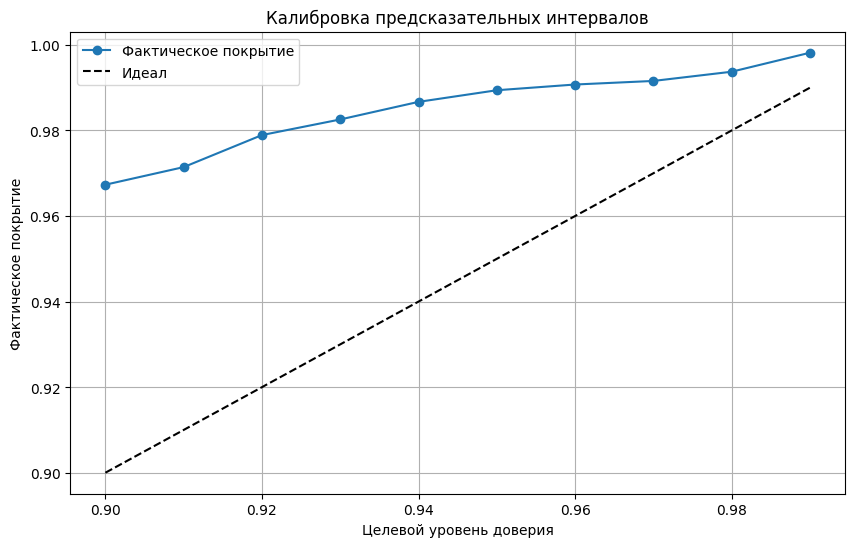

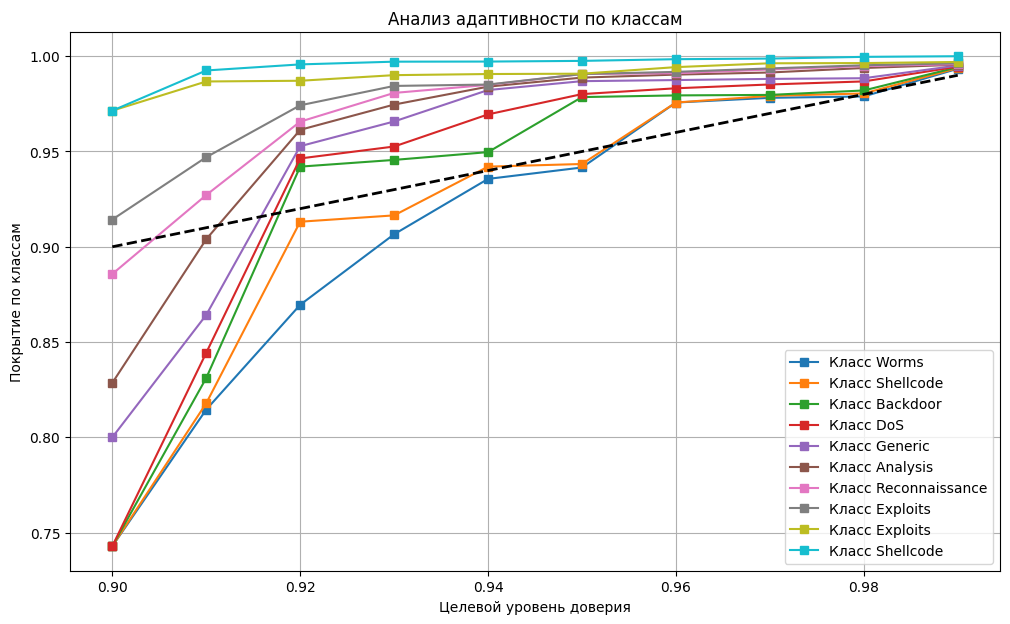

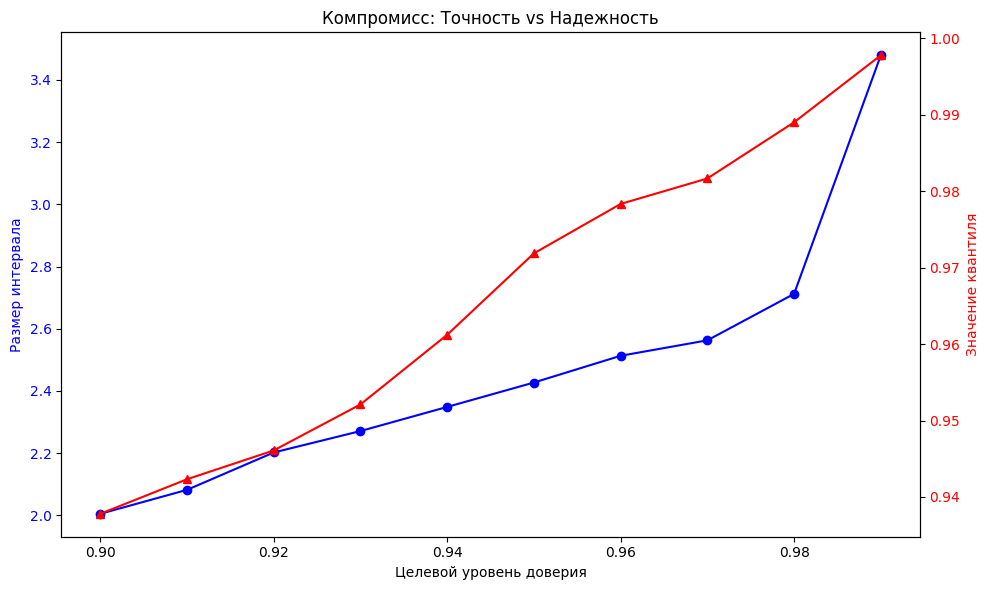

In [31]:
# Диапазон целевых уровней доверия
confidence_levels = np.linspace(0.90, 0.99, 10)

# 1. График основного покрытия
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, coverageS, 'o-', label='Фактическое покрытие')
plt.plot(confidence_levels, confidence_levels, 'k--', label='Идеал')
plt.xlabel('Целевой уровень доверия')
plt.ylabel('Фактическое покрытие')
plt.legend()
plt.title('Калибровка предсказательных интервалов')
plt.grid(True)

# 2. Покрытие по классам
plt.figure(figsize=(12, 7))
i = 0
for lst in class_coveragesS.values():
    keys = []
    values = []
    
    for key, value in lst:
        keys.append(key)
        values.append(value)
    plt.plot(confidence_levels, values, 's-', label=f'Класс {keys[i]}')
    i =i + 1

# for cls, cov in class_coveragesS.values():
#     print('cls = ', cls, " cov = ", cov )
#     plt.plot(confidence_levels, cov, 's-', label=f'Класс {cls}')
plt.plot(confidence_levels, confidence_levels, 'k--', linewidth=2)
plt.xlabel('Целевой уровень доверия')
plt.ylabel('Покрытие по классам')
plt.title('Анализ адаптивности по классам')
plt.legend()
plt.grid(True)

# 3. Размер интервала и квантиль
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(confidence_levels, avg_sizeS, 'bo-', label='Средний размер интервала')
ax1.set_xlabel('Целевой уровень доверия')
ax1.set_ylabel('Размер интервала', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(confidence_levels, quantileS, 'r^-', label='Квантиль')
ax2.set_ylabel('Значение квантиля', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Компромисс: Точность vs Надежность')
fig.tight_layout()

### 16.Критерии оценки эффективности ACP

1. Покрытие (Coverage)

In [32]:
def calculate_coverage(pred_sets, true_labels):
    return np.mean([true in pred for pred, true in zip(pred_sets, true_labels)])

# Сравнение с теоретическим ожиданием (1-α)
print(f"Эмпирическое покрытие: {calculate_coverage(awcp_prediction_sets, y_test):.3f} (ожидалось {1-alpha:.3f})")

Эмпирическое покрытие: 0.989 (ожидалось 0.990)


2. Средний размер предсказанного множества

In [33]:
avg_size = np.mean([len(ps) for ps in awcp_prediction_sets])
print(f"Средний размер множества: {avg_size:.2f}")

Средний размер множества: 2.43


3. Класс-специфичные метрики

In [34]:
for class_idx in range(num_classes):
    mask = (y_test == class_idx)
    if mask.sum() > 0:
        class_cov = calculate_coverage([awcp_prediction_sets[i] for i in torch.where(torch.from_numpy(mask) )[0]], 
                                     y_test[mask])
        print(f"{label_encoder.classes_[class_idx]:15s}: {class_cov:.3f} coverage")

Analysis       : 0.989 coverage
Backdoor       : 0.961 coverage
DoS            : 0.975 coverage
Exploits       : 0.991 coverage
Fuzzers        : 0.994 coverage
Generic        : 0.984 coverage
Normal         : 0.996 coverage
Reconnaissance : 0.990 coverage
Shellcode      : 0.904 coverage
Worms          : 0.829 coverage


4. Индекс точности покрытия:

In [35]:
def coverage_balance(adaptive_sets, y_test):
    class_covs = []
    for class_idx in torch.unique(y_test):
        mask = (y_test == class_idx)
        class_covs.append(calculate_coverage([adaptive_sets[i] for i in torch.where(mask)[0]], 
                                         y_test[mask]))
    return np.std(class_covs)  # Чем меньше, тем равномернее покрытие

print(f"Сбалансированность покрытия: {coverage_balance(awcp_prediction_sets, torch.tensor(y_test) ):.4f}")

Сбалансированность покрытия: 0.0513


Вывод: Адаптивный метод дает хорошую сбалансированность между классами (0.0513 < 0.1) и высокое эмпирическое покрытие.